In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from datetime import datetime
from datetime import timedelta
import random
from importlib import reload
from IPython.display import Audio
import m5forecasting as m5
import matplotlib.pyplot as plt
sound_file = './sound/radio.wav'
from collections import Counter

In [3]:
df = m5.df
all_data = m5.all_data

In [299]:
events = [event[0] for event in list(Counter(m5.calendar["event_name_1"]).items())]
event_dict = {}
for idx, event in enumerate(events):
    event_dict[event] = idx

eventTypes = [eventType[0] for eventType in list(Counter(m5.calendar["event_type_1"]).items())]
event_type_dict = {}
for idx, eventType in enumerate(eventTypes):
    event_type_dict[eventType] = idx

def getEvent(day):
    row = m5.calendar.iloc[day - 1]
    event_name = event_dict[row["event_name_1"]]
    event_type = event_type_dict[row["event_type_1"]]
    return np.array([event_name, event_type])

In [294]:
%%time
for i in range(1913 * 10):
    temp = m5.calendar[m5.calendar.d == "d_" + str((i + 1) % 1913)]

CPU times: user 9.38 s, sys: 30.3 ms, total: 9.41 s
Wall time: 9.43 s


In [295]:
%%time
for i in range(1913 * 10):
    temp = m5.calendar.iloc[i % 1913]

CPU times: user 2.27 s, sys: 6.6 ms, total: 2.27 s
Wall time: 2.28 s


## Feature Generation

In [4]:
def getYearMonthDay(day):
    temp = datetime(2011,1,28) + timedelta(days=day)
    return [temp.year, temp.month, temp.day]

def getDay(day):
    temp = day % 7
    return [temp, int(temp > 0 and temp < 3)]

def getSnapValue(day, state_index):
    return int(m5.calendar.iloc[day - 1, 11 + state_index])

events = [event[0] for event in list(Counter(m5.calendar["event_name_1"]).items())]
event_dict = {}
for idx, event in enumerate(events):
    event_dict[event] = idx

eventTypes = [eventType[0] for eventType in list(Counter(m5.calendar["event_type_1"]).items())]
event_type_dict = {}
for idx, eventType in enumerate(eventTypes):
    event_type_dict[eventType] = idx

def getEvent(day):
    row = m5.calendar.iloc[day - 1]
    event_name = event_dict[row["event_name_1"]]
    event_type = event_type_dict[row["event_type_1"]]
    return np.array([event_name, event_type])

# item number, item department, item category, store, state
departmentInt = {}
current_id = "HOBBIES_1"
count = 0
for i in range(3049):
    if df.iloc[i]["dept_id"] != current_id or i == 3048:
        departmentInt[current_id] = count
        count += 1
        current_id = df.iloc[i]["dept_id"]

categoryInt = {}
current_id = "HOBBIES"
count = 0
for i in range(3049):
    if df.iloc[i]["cat_id"] != current_id or i == 3048:
        categoryInt[current_id] = count
        count += 1
        current_id = df.iloc[i]["cat_id"]

storeInt = {}
current_id = "CA_1"
count = 0
for i in range(0,30490,3049):
    if df.iloc[i]["store_id"] != current_id:
        storeInt[current_id] = count
        count += 1
        current_id = df.iloc[i]["store_id"]
        storeInt[current_id] = count

stateInt = {}
current_id = "CA"
count = 0
for i in range(0,30490,3049):
    if df.iloc[i]["state_id"] != current_id:
        stateInt[current_id] = count
        count += 1
        current_id = df.iloc[i]["state_id"]
        stateInt[current_id] = count

def generateTrainingData(start_day, end_day, lags, rolling, all_data, withLabels = True, verbose=False):
    num_days = end_day - start_day + 1
    num_series = 30490
    total_entries = num_days * num_series
    training_data = np.zeros((total_entries, len(lags)))
    categoricalfeatures = [0] * len(lags)
    if withLabels:
        training_labels = np.zeros(total_entries)
    
    # lag features
    count = 0
    for time_series_idx in range(30490):
        for i in range(end_day - num_days,end_day):
            training_data[count] = all_data[time_series_idx, [i - lag for lag in lags]]
            if withLabels:
                training_labels[count] = all_data[time_series_idx, i]
            count += 1
    
    if verbose:
        print("Finished lag features")
    
    # rolling lag features
    count = 0
    categoricalfeatures.extend([0] * len(rolling))
    temp_training = np.zeros((total_entries, len(rolling)))
    for time_series_idx in range(30490):
        for i in range(end_day - num_days,end_day):
            temp_training[count] = [all_data[time_series_idx, [i - lag for lag in rolling_lags]].sum() / len(rolling_lags) for rolling_lags in rolling]
            count += 1
    training_data = np.concatenate((training_data, temp_training), axis=1)
    
    if verbose:
        print("Finished rolling lag features")
    
    # item features - item number, department, category, store, state
    temp_training = np.zeros((total_entries, 5))
    categoricalfeatures.extend([1] * 5)
    for i in range(0, total_entries, num_days):
        item_number = i // num_days % 3049
        temp_training[i:i + num_days, 0] = item_number
        temp_training[i:i + num_days, 1] = departmentInt[df["dept_id"].iloc[item_number]]
        temp_training[i:i + num_days, 2] = categoryInt[df["cat_id"].iloc[item_number]]
        temp_training[i:i + num_days, 3] = storeInt[df["store_id"].iloc[i // num_days]]
        temp_training[i:i + num_days, 4] = stateInt[df["state_id"].iloc[i // num_days]]
    training_data = np.concatenate((training_data, temp_training), axis=1)
    
    if verbose:
        print("Finished item features")
    
    # snap feature
    temp_training = np.zeros((total_entries, 1))
    categoricalfeatures.append(1)
    for idx, day in enumerate(range(start_day, end_day + 1)):
        temp_training[range(idx, idx + 3049 * 4 * num_days, num_days), 0] = getSnapValue(day, 0)
        temp_training[range(idx + 3049 * 4 * num_days, idx + 3049 * 7 * num_days, num_days), 0] = getSnapValue(day, 1)
        temp_training[range(idx + 3049 * 7 * num_days, idx + 3049 * 10 * num_days, num_days), 0] = getSnapValue(day, 2)
    training_data = np.concatenate((training_data, temp_training), axis=1)
    
    # month, day, year
    temp_training = np.zeros((total_entries, 3))
    categoricalfeatures.extend([1] * 3)
    for i in range(total_entries):
        temp_training[i] = getYearMonthDay(i % num_days + (end_day + 1 - num_days))
    training_data = np.concatenate((training_data, temp_training), axis=1)
    
    if verbose:
        print("Finished date features")
    
    # special events
    temp_training = np.zeros((total_entries, 2))
    categoricalfeatures.extend([1] * 2)
    for idx, day in enumerate(range(start_day, end_day + 1)):
        temp_training[range(idx, total_entries, num_days)] = getEvent(day)
    training_data = np.concatenate((training_data, temp_training), axis=1)
    
    # day of week and is weekend
    temp_training = np.zeros((total_entries, 2))
    categoricalfeatures.extend([1] * 2)
    for i in range(total_entries):
        temp_training[i] = getDay(i % num_days + (end_day + 1 - num_days))
    training_data = np.concatenate((training_data, temp_training), axis=1)
    
    if verbose:
        print("Finished day features")
    
    if withLabels:
        return training_data, training_labels, [idx for idx, val in enumerate(categoricalfeatures) if val == 1]
    else:
        return training_data

In [367]:
dept_idxs = []
current_dep = ""
for i in range(3049):
    if df.iloc[i]["dept_id"] != current_dep:
        current_dep = df.iloc[i]["dept_id"]
        dept_idxs.append(i)

In [372]:
dept_idxs

[0, 416, 565, 1097, 1612, 1828, 2226]

## Model Training / Testing

In [627]:
def custom_asymmetric_train(y_pred, y_true):
    # y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual < 0, -2.0 * residual, -2 * residual * 1.15)
    hess = np.where(residual < 0, 2.0, 2.0 * 1.15)
    return grad, hess

def custom_asymmetric_valid(y_pred, y_true):
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual**2)*10.0, residual**2) 
    return "custom_asymmetric_eval", np.mean(loss), False

In [608]:
np.power(np.arange(4), 2)

array([0, 1, 4, 9])

In [5]:
def Level_12_WRMSSE(y_pred, y_true):
    y_true = y_true.get_label()
    diff = (y_true - y_pred).astype("float")
    diff_squared = (diff * diff).reshape((30490, 28))
    return "Lev 12", np.sum(np.sqrt(np.sum(diff_squared, axis = 1)) * m5.weights[12] / 12.0), False

def Level_1_WRMSSE(y_pred, y_true):
    y_true = y_true.get_label()
    diff = (y_true - y_pred).astype("float").reshape((30490, 28))
    diff_squared = np.square(m5.transformer[1](diff))
    return "Lev 1", np.sum(np.sqrt(np.sum(diff_squared, axis = 1)) * m5.weights[1] / 12.0), False

In [391]:
def Level_1_12_WRMSSE(y_pred, y_true):
    response1 = Level_1_WRMSSE(y_pred, y_true)
    response12 = Level_12_WRMSSE(y_pred, y_true)
    return "Lev 1: {} Lev 12:".format(response1[1]), response12[1], False

## Ignore Above

In [5]:
def byLevelWRMSSE(y_pred, y_true, level):
    y_true = y_true.get_label()
    diff = (y_true - y_pred).astype("float").reshape((30490, 28))
    if level > 0:    
        diff_squared = np.square(m5.transformer[level](diff))
        return "Lev {}".format(level), np.sum(np.sqrt(np.sum(diff_squared, axis = 1)) * m5.weights[level] / 12.0), False
    else:
        total_loss = 0.0
        for i in range(1,13):
            diff_squared = np.square(m5.transformer[i](diff))
            total_loss += np.sum(np.sqrt(np.sum(diff_squared, axis = 1)) * m5.weights[i] / 12.0)
        return "WRMSSE", total_loss, False

In [6]:
def getFudged(y_pred, y_true):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    full_store_range = range((3049 * 8 + 2226) * 28, 3049 * 9 * 28)
    return "Fudged", np.sqrt(np.sum(np.square(residual[full_store_range].reshape((3049 - 2226, 28)).sum(axis = 0)))), True

def getNormal(y_pred, y_true):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    fudger = 3049 * 8 + 2297
    residual[fudger * 28:(fudger + 1) * 28] = 0
    full_store_range = range((3049 * 8 + 2226) * 28, 3049 * 9 * 28)
    return "Normal", np.sqrt(np.sum(np.square(residual[full_store_range].reshape((3049 - 2226, 28)).sum(axis = 0)))), True

In [7]:
minWeight = min([i for i in m5.weights[12] if i != 0])
maximum = m5.weights[12].max()
def level12Weighted(y_pred, y_true):
    y_true = y_true.get_label()
    num_days = int(len(y_pred) / 30490)
    residual = (y_true - y_pred).astype("float")
    for i in range(30490): 
        residual[i * num_days:(i+1) * num_days] = max(minWeight, m5.weights[12][i]) / maximum * residual[i * num_days:(i+1) * num_days]
    grad = -5.0 * residual
    hess = 5.0 * np.ones(residual.shape)
    return grad, hess

In [8]:
minWeight = min([i for i in m5.weights[12] if i != 0])
maximum = m5.weights[12].max()
def level12WeightedFudged(y_pred, y_true):
    y_true = y_true.get_label()
    num_days = int(len(y_pred) / 30490)
    residual = (y_true - y_pred).astype("float")
    for i in range(30490): 
        residual[i * num_days:(i+1) * num_days] = max(minWeight, m5.weights[12][i]) / maximum * residual[i * num_days:(i+1) * num_days]
    for store in range(10):
        fudger = 3049 * store + 2297
        full_store_range = range((3049 * store + 2226) * num_days, 3049 * (store + 1) * num_days)
        summed_residuals = (y_true - y_pred)[full_store_range].reshape((3049 - 2226, num_days)).sum(axis = 0)
        residual[fudger * num_days: (fudger + 1) * num_days] = summed_residuals / 1000.0
    grad = -5.0 * residual
    hess = 5.0 * np.ones(residual.shape)
    return grad, hess

In [730]:
current_row = ""
l9_idxs = []
for idx, row in enumerate(df["dept_id"].tolist()):
    if row != current_row:
        l9_idxs.append(idx)
        current_row = row
l9_idxs.append(30490)

In [522]:
len(l9_idxs)

71

In [530]:
np.tile(np.array([1,2]), 5)

array([1, 2, 1, 2, 1, 2, 1, 2, 1, 2])

In [473]:
100 / m5.weights[9][62]

5239767.172573334

In [381]:
np.array([[1,2,3],[2,3,4],[-1,4,-2]]).sum(axis=0)

array([2, 9, 5])

In [336]:
minWeight = min([i for i in m5.weights[12] if i != 0])
maximum = m5.weights[12].max()
def level12WeightedAsymmetric(y_pred, y_true):
    y_true = y_true.get_label()
    num_days = int(len(y_pred) / 30490)
    residual = (y_true - y_pred).astype("float")
    for i in range(30490): 
        residual[i * num_days:(i+1) * num_days] = max(minWeight, m5.weights[12][i]) / maximum * residual[i * num_days:(i+1) * num_days]
    grad = np.where(residual < 0, -5.0 * residual, -5.0 * residual * 1.07)
    hess = np.where(residual < 0, 5.0, 5.0 * 1.07)
    return grad, hess

In [19]:
def groupByDay(y_pred, y_true):
    y_true = y_true.get_label()
    num_days = int(len(y_pred) / 30490)
    residual = (y_true - y_pred).astype("float")
    grad = np.zeros(y_pred.shape)
    hess = np.zeros(y_pred.shape)
    for i in range(num_days):
        all_series = residual[range(i, total, num_days)]
        grad[range(i, total, num_days)] -= all_series.sum() / (30490 * 2.0)
    return grad, hess

In [20]:
def combined1(y_pred, y_true):
    l12grad, l12hess = level12Weighted(y_pred, y_true)
    groupgrad, grouphess = groupByDay(y_pred, y_true)
    return l12grad + groupgrad, l12hess + grouphess

In [ ]:
def groupByTimeSeries():
    # put all data from one time series under one sqrt so that it affects the gradient
    for i in range(30490):
        residual[i * num_days: (i+1) * num_days]

Data
- SNAP data
- weather data
- rolling averages
- seasonal data
- prices?

Custom Loss
- Independent gradients with RMSE and weights
- Dependent gradients - group by time series and group by day
- Various levels

In [24]:
def expandWeights(weight, days):
    new_weights = np.zeros(len(weight) * days)
    for i in range(days):
        new_weights[range(i, len(new_weights), days)] = weight
    return new_weights

In [86]:
# Saving features so they don't need to be rerun
# %%time
# np.save("features/training_data.npy", training_data)
# np.save("features/training_labels.npy", training_data)
# np.save("features/categories.npy", categories)
# np.save("features/val_data.npy", val_data)
# np.save("features/val_labels.npy", val_labels)

In [684]:
grad = 0
hess = 0
def custom_tweedie(y_pred, y_true, rho):
    global grad, hess
    y_true = y_true.get_label().astype("float")
    epsilon = 0.000001
    y_pred = y_pred.astype("float")
    y_pred = np.where(y_pred < epsilon, epsilon, y_pred)
    grad = np.power(y_pred, -0.5) / 2.0 - 0.5 * y_true / np.power(y_pred, 1.5)
    
    # grad = -y_true * np.power(y_pred, -rho) + np.power(y_pred, 1 - rho)
    hess = y_true * rho * np.power(y_pred, -rho-1) + (1-rho) * np.power(y_pred, -rho)
    # grad = 1000000000.0 * grad
    # hess = 1000000000.0 * hess
    return grad, hess

In [677]:
grad = 0
hess = 0
def custom_tweedie2(y_pred, y_true, rho):
    global grad, hess
    y_true = y_true.get_label().astype("float")
    y_pred = y_pred.astype("float")
    # epsilon = 0.000001
    # y_pred = np.where(y_pred < epsilon, epsilon, y_pred)
    grad = -y_true * np.exp(y_pred * (1-rho)) + np.exp(y_pred * (2 - rho))
    hess = -y_true * (1 - rho) * np.exp(y_pred * (1 - rho)) + (2 - rho) * np.exp(y_pred * (2-rho))
    # grad = 1000000000.0 * grad
    # hess = 1000000000.0 * hess
    return grad, hess

In [714]:
minWeight = min([i for i in m5.weights[12] if i != 0])
maximum = m5.weights[12].max()
def level12Level9(y_pred, y_true):
    y_true = y_true.get_label()
    num_days = int(len(y_pred) / 30490)
    residual = (y_true - y_pred).astype("float")
    reshaped = residual.reshape((30490, num_days))
    for i in range(30490): 
        residual[i * num_days:(i+1) * num_days] = max(minWeight, m5.weights[12][i]) / maximum * residual[i * num_days:(i+1) * num_days]
    for start_item, end_item in zip(l9_idxs[:-1], l9_idxs[1:]):
        summed_residuals = reshaped[start_item:end_item].sum(axis = 0)
        residual[start_item * num_days:end_item * num_days] += np.tile(summed_residuals / 200.0, end_item - start_item)
    grad = np.where(residual < 0, -5.0 * residual, -5.0 * 1.2 * residual)
    hess = np.where(residual < 0, 5.0, 5.0 * 1.2) 
    return grad, hess

In [98]:
%%time
# RECURSIVE
lags = list(range(7, 15, 7)) + list(range(15, 40, 1))
rolling = [range(1,15), range(4,11), range(7, 14), range(28, 28 * 6, 28)]
start_day = 1500
end_day = 1885
num_train_days = end_day - start_day + 1
num_val_days = 1913 - end_day + 1
training_data, training_labels, categories = generateTrainingData(start_day, end_day, lags, rolling, all_data, verbose=True)

val_data, val_labels, _ = generateTrainingData(end_day + 1, 1913, lags, rolling, all_data, verbose=True)

CPU times: user 9 µs, sys: 1e+03 ns, total: 10 µs
Wall time: 14.1 µs


In [93]:
%%time
# 28 DAY
lags = list(range(28, 56, 1))
rolling = [range(28,35), range(35,42), range(42, 49), range(28, 28 * 6, 28)]
start_day = 1500
end_day = 1885
num_train_days = end_day - start_day + 1
num_val_days = 1913 - end_day + 1
training_data, training_labels, categories = generateTrainingData(start_day, end_day, lags, rolling, all_data, verbose=True)

val_data, val_labels, _ = generateTrainingData(end_day + 1, 1913, lags, rolling, all_data, verbose=True)

Finished lag features
Finished rolling lag features
Finished item features
Finished date features
Finished day features
Finished lag features
Finished rolling lag features
Finished item features
Finished date features
Finished day features
CPU times: user 7min 1s, sys: 12 s, total: 7min 13s
Wall time: 7min 14s


In [13]:
training_dataset = lgb.Dataset(training_data, 
                               label=training_labels, 
                               free_raw_data=False)# , 
                               # weight=expandWeights(m5.weights[12], num_train_days))
val_dataset = lgb.Dataset(val_data,
                          label=val_labels, 
                          free_raw_data=False, 
                          reference=training_dataset)

In [103]:
params = {
    'boosting_type': 'gbdt',
    'n_jobs': -1,
    'seed': 42,
    'bagging_fraction': 0.2,
    'bagging_freq': 2, 
    'colsample_bytree': 0.95,
    'colsample_bynode': 0.5,
    'num_leaves': 1000,
    'lambda_l1': 0.2,
    'lambda_l2': 0.2,
    'metric': "None",
    'max_bin': 3049,
    'first_metric_only': True,
}

def learningRate(num_round):
    if num_round < 500:
        return .2 - 0.02 * num_round / 100
    return 0.08 + 0.01 * num_round / 500

In [104]:
preds = 0
def MSELoss(y_pred, y_true):
    global preds
    global num_rounds
    num_rounds += 1
    preds = y_pred
    y_true = y_true.get_label()
    num_days = int(len(y_pred) / 30490)
    residual = (y_true - y_pred).astype("float")
    reshaped = residual.reshape((30490, num_days))
    if num_rounds < 700:
        return tuple(level12MSE(reshaped, num_days, weights = np.power(m5.weights[12] / m5.weights[12].max(), 0.3), p = 1.0)
                     + level9MSE(reshaped, num_days, p = 1.0, weights = m5.weights[9]))
    elif num_rounds < 1000:
        return tuple(level9MSE(reshaped, num_days, p = 1.0, weights = m5.weights[9]) + 
                     level1MSE(reshaped, num_days, p = 1 / 30490.) + 
                     level12MSE(reshaped, num_days, p = 0.8, weights = np.power(m5.weights[12] / m5.weights[12].max(), 0.6)))
    else:
        return tuple(level12MSE(reshaped, num_days, p = 0.6, weights = np.power(m5.weights[12] / m5.weights[12].max(), 1.0)) + 
                     level10MSE(reshaped, num_days, p = 0.1, weights = m5.weights[10]) +
                     level4MSE(reshaped, num_days, p = 1 / 14000., weights = m5.weights[4]))

In [ ]:
%%time
num_rounds = 0
model = lgb.train(params, 
                  training_dataset, 
                  categorical_feature=categories, 
                  num_boost_round=500,
                  valid_sets = [val_dataset],
                  fobj=MSELoss,
                  feval = lambda y_pred, y_true: [byLevelWRMSSE(y_pred, y_true, level) for level in [0, 1, 3, 6, 9, 12]] + [getNormal(y_pred, y_true)],
                  early_stopping_rounds=120,
                  verbose_eval=3,
                  valid_names=None,
                  learning_rates=learningRate
                 )

Training until validation scores don't improve for 120 rounds
[3]	valid_0's WRMSSE: 4.72698	valid_0's Lev 1: 0.537173	valid_0's Lev 3: 0.467147	valid_0's Lev 6: 0.466381	valid_0's Lev 9: 0.394834	valid_0's Lev 12: 0.113537	valid_0's Normal: 11499.3
[6]	valid_0's WRMSSE: 4.2297	valid_0's Lev 1: 0.479011	valid_0's Lev 3: 0.416886	valid_0's Lev 6: 0.416332	valid_0's Lev 9: 0.353016	valid_0's Lev 12: 0.106092	valid_0's Normal: 10320.3
[9]	valid_0's WRMSSE: 3.79128	valid_0's Lev 1: 0.427576	valid_0's Lev 3: 0.372456	valid_0's Lev 6: 0.372074	valid_0's Lev 9: 0.316117	valid_0's Lev 12: 0.099868	valid_0's Normal: 9268.59
[12]	valid_0's WRMSSE: 3.40322	valid_0's Lev 1: 0.38191	valid_0's Lev 3: 0.333065	valid_0's Lev 6: 0.332798	valid_0's Lev 9: 0.283454	valid_0's Lev 12: 0.0946099	valid_0's Normal: 8354.86
[15]	valid_0's WRMSSE: 3.06052	valid_0's Lev 1: 0.341442	valid_0's Lev 3: 0.298179	valid_0's Lev 6: 0.298041	valid_0's Lev 9: 0.25461	valid_0's Lev 12: 0.0901952	valid_0's Normal: 7533.25
[1

[132]	valid_0's WRMSSE: 0.546076	valid_0's Lev 1: 0.026137	valid_0's Lev 3: 0.0374911	valid_0's Lev 6: 0.0382648	valid_0's Lev 9: 0.0502061	valid_0's Lev 12: 0.0693457	valid_0's Normal: 1135.66
[135]	valid_0's WRMSSE: 0.544624	valid_0's Lev 1: 0.0259622	valid_0's Lev 3: 0.037328	valid_0's Lev 6: 0.0381063	valid_0's Lev 9: 0.0500746	valid_0's Lev 12: 0.0693418	valid_0's Normal: 1126.04
[138]	valid_0's WRMSSE: 0.541801	valid_0's Lev 1: 0.025617	valid_0's Lev 3: 0.0370621	valid_0's Lev 6: 0.0377926	valid_0's Lev 9: 0.0498333	valid_0's Lev 12: 0.0693298	valid_0's Normal: 1113.69
[141]	valid_0's WRMSSE: 0.540159	valid_0's Lev 1: 0.025406	valid_0's Lev 3: 0.0368902	valid_0's Lev 6: 0.0376179	valid_0's Lev 9: 0.0496959	valid_0's Lev 12: 0.0693204	valid_0's Normal: 1103.21
[144]	valid_0's WRMSSE: 0.538722	valid_0's Lev 1: 0.0252529	valid_0's Lev 3: 0.0367864	valid_0's Lev 6: 0.0374513	valid_0's Lev 9: 0.049559	valid_0's Lev 12: 0.0693162	valid_0's Normal: 1089.91
[147]	valid_0's WRMSSE: 0.5367

[261]	valid_0's WRMSSE: 0.515143	valid_0's Lev 1: 0.0232759	valid_0's Lev 3: 0.0345188	valid_0's Lev 6: 0.0348455	valid_0's Lev 9: 0.0470309	valid_0's Lev 12: 0.0692384	valid_0's Normal: 937.778


In [70]:
current_row = ""
l9_idxs = []
for idx, row in enumerate(df["dept_id"].tolist()):
    if row != current_row:
        l9_idxs.append(idx)
        current_row = row
l9_idxs.append(30490)

current_row = ""
l8_idxs = []
for idx, row in enumerate(df["cat_id"].tolist()):
    if row != current_row:
        l8_idxs.append(idx)
        current_row = row
l8_idxs.append(30490)

l3_idxs = range(0, 30491, 3049)
l2_idxs = [0, 3049 * 4, 3049 * 7, 30490]

def level8MSE(reshapedResiduals, num_days, weights = np.ones(30), p = 1.0):
    residual = np.zeros((30490, num_days))
    for w, start_item, end_item in zip(weights, l8_idxs[:-1], l8_idxs[1:]):
        summed_residuals = w * reshapedResiduals[start_item:end_item].sum(axis = 0)
        residual[start_item * num_days:end_item * num_days] += np.tile(summed_residuals, end_item - start_item)
    grad = -2.0 * residual * p
    hess = 2.0 * np.ones(residual.shape) * p
    return np.array([grad, hess])

def level3MSE(reshapedResiduals, num_days, weights = np.ones(10), p = 1.0):
    residual = np.zeros((30490 * num_days))
    for w, start_item, end_item in zip(weights, l3_idxs[:-1], l3_idxs[1:]):
        summed_residuals = w * reshapedResiduals[start_item:end_item].sum(axis = 0)
        residual[start_item * num_days:end_item * num_days] += np.tile(summed_residuals, end_item - start_item)
    grad = -2.0 * residual * p
    hess = 2.0 * np.ones(residual.shape) * p
    return np.array([grad, hess])

def level2MSE(reshapedResiduals, num_days, weights = np.ones(3), p = 1.0):
    residual = np.zeros((30490 * num_days))
    for w, start_item, end_item in zip(weights, l2_idxs[:-1], l2_idxs[1:]):
        summed_residuals = weights[idx] * reshapedResiduals[start_item:end_item].sum(axis = 0)
        residual[start_item * num_days:end_item * num_days] += np.tile(summed_residuals, end_item - start_item)
    grad = -2.0 * residual * p
    hess = 2.0 * np.ones(residual.shape) * p
    return np.array([grad, hess])

residual = 0
grad = 0

def level1MSE(reshapedResiduals, num_days, weights = np.ones(1), p = 1.0):
    global residual, grad
    residual = np.tile(reshapedResiduals.sum(axis = 0), 30490)
    grad = -2.0 * residual * p
    hess = 2.0 * np.ones(residual.shape) * p
    return np.array([grad, hess])

def level4MSE(reshapedResiduals, num_days, weights = np.ones(3), p = 1.0):
    residual = np.zeros((30490 * num_days))
    aggregated = m5.Transform_4(reshapedResiduals)
    combined = np.concatenate((np.tile(weights[0] * aggregated[0], 565), 
                               np.tile(weights[1] * aggregated[1], 1047), 
                               np.tile(weights[2] * aggregated[2], 1437)))
    for store in range(10):
        residual[store * 3049 * num_days:(store + 1) * 3049 * num_days] = combined
    grad = -2.0 * residual * p
    hess = 2.0 * np.ones(residual.shape) * p
    return np.array([grad, hess])

occurences = np.array(list(Counter(df["dept_id"].tolist()).values())) // 10
def level5MSE(reshapedResiduals, num_days, weights = np.ones(7), p = 1.0):
    residual = np.zeros((30490 * num_days))
    aggregated = m5.Transform_5(reshapedResiduals)
    combined = np.concatenate([np.tile(weights[i] * aggregated[i], occurences[i]) for i in range(7)])
    for store in range(10):
        residual[store * 3049:(store + 1) * 3049] = combined
    grad = -2.0 * residual * p
    hess = 2.0 * np.ones(residual.shape) * p
    return np.array([grad, hess])

def level6Helper(residual, reshapedResiduals, num_days, stores, weights = np.ones(3)):
    cat1 = np.zeros(num_days)
    cat2 = np.zeros(num_days)
    cat3 = np.zeros(num_days)
    for i in stores:
        cat1 += np.sum(reshapedResiduals[3049 * i:3049 * i + 565], axis=0)
        cat2 += np.sum(reshapedResiduals[3049 * i + 565:3049 * i + 1612], axis=0)
        cat3 += np.sum(reshapedResiduals[3049 * i + 1612:3049 * (i + 1)], axis=0)
    for i in stores:
        residual[3049 * i * num_days:(3049 * i + 565) * num_days] = np.tile(weights[0] * cat1, 565)
        residual[(3049 * i + 565) * num_days:(3049 * i + 1612) * num_days] = np.tile(weights[1] * cat2, 1047)
        residual[(3049 * i + 1612) * num_days:3049 * (i + 1) * num_days] = np.tile(weights[2] * cat3, 1437)

def level6MSE(reshapedResiduals, num_days, weights = np.ones(9), p = 1.0):
    residual = np.zeros((30490 * num_days))
    level6Helper(residual, reshapedResiduals, num_days, range(4), weights = weights[:3])
    level6Helper(residual, reshapedResiduals, num_days, range(4,7), weights = weights[3:6])
    level6Helper(residual, reshapedResiduals, num_days, range(7,10), weights = weights[6:9])
    grad = -2.0 * residual * p
    hess = 2.0 * np.ones(residual.shape) * p
    return np.array([grad, hess])

dep_idxs = l9_idxs[:8]
def level7Helper(residual, reshapedResiduals, num_days, stores, weights = np.ones(7)):
    deps = np.zeros((7, num_days))
    for i in stores:
        for dep in range(7):
            deps[dep] += np.sum(reshapedResiduals[3049 * i + dep_idxs[dep]:3049 * i + dep_idxs[dep + 1]], axis = 0)
    for i in stores:
        for dep in range(7):
            residual[(3049 * i + dep_idxs[dep]) * num_days:(3049 * i + dep_idxs[dep + 1]) * num_days] = np.tile(
                weights[dep] * deps[dep], occurences[dep])

def level7MSE(reshapedResiduals, num_days, weights = np.ones(21), p = 1.0):
    residual = np.zeros((30490 * num_days))
    level7Helper(residual, reshapedResiduals, num_days, range(4), weights = weights[:7])
    level7Helper(residual, reshapedResiduals, num_days, range(4,7), weights = weights[7:14])
    level7Helper(residual, reshapedResiduals, num_days, range(7,10), weights = weights[14:21])
    grad = -2.0 * residual * p
    hess = 2.0 * np.ones(residual.shape) * p
    return np.array([grad, hess])

def level9MSE(reshapedResiduals, num_days, weights = np.ones(70), p = 1.0):
    residual = np.zeros((30490 * num_days))
    for weight, start_item, end_item in zip(weights, l9_idxs[:-1], l9_idxs[1:]):
        summed_residuals = weight * reshapedResiduals[start_item:end_item].sum(axis = 0)
        residual[start_item * num_days:end_item * num_days] += np.tile(summed_residuals, end_item - start_item)
    grad = -2.0 * residual * p
    hess = 2.0 * np.ones(residual.shape) * p
    return np.array([grad, hess])

def level12MSE(reshapedResiduals, num_days, weights = np.ones(30490), p = 1.0):
    residual = np.zeros((30490 * num_days))
    for i in range(30490): 
        residual[i * num_days:(i+1) * num_days] = weights[i] * reshapedResiduals[i]
    grad = -2.0 * residual * p
    hess = 2.0 * np.ones(residual.shape) * p
    return np.array([grad, hess])

def level10MSE(reshapedResiduals, num_days, weights = np.ones(3049), p = 1.0):
    residual = np.zeros((30490 * num_days))
    for i in range(3049):
        item_total = np.sum(reshapedResiduals[i::3049],axis=0)
        for store in range(10):
            residual[(3049 * store + i) * num_days:(3049 * store + i + 1) * num_days] = weights[i] * item_total
    grad = -2.0 * residual * p
    hess = 2.0 * np.ones(residual.shape) * p
    return np.array([grad, hess])

def level11MSE(reshapedResiduals, num_days, weights = np.ones(9147), p = 1.0):
    residual = np.zeros((30490 * num_days))
    california = reshapedResiduals[:3049 * 4]
    for i in range(3049):
        item_total = np.sum(california[i::3049],axis=0)
        for store in range(4):
            residual[(3049 * store + i) * num_days:(3049 * store + i + 1) * num_days] = weights[i] * item_total
    texas = reshapedResiduals[3049 * 4:3049 * 7]
    for i in range(3049):
        item_total = np.sum(texas[i::3049],axis=0)
        for store in range(4, 7):
            residual[(3049 * store + i) * num_days:(3049 * store + i + 1) * num_days] = weights[i + 3049] * item_total
    wisconsin = reshapedResiduals[3049 * 7:]
    for i in range(3049):
        item_total = np.sum(wisconsin[i::3049],axis=0)
        for store in range(7,10):
            residual[(3049 * store + i) * num_days:(3049 * store + i + 1) * num_days] = weights[i + 6098] * item_total
    grad = -2.0 * residual * p
    hess = 2.0 * np.ones(residual.shape) * p
    return np.array([grad, hess])    

- RMSE - 35.9
- Tweedie - 55.8
- Custom Lev 12 - 46.8
- Custom Lev 12 Asymmetric - 57.1
- Custom Lev 12 Fudged - 104.0
- Custom Lev 12 + 9 Asymmetric - 190.0

## Saving Model

In [556]:
model.save_model('models/level9-12-asymmetric.txt')

In [537]:
model = lgb.Booster(model_file='models/level9-12.txt')

In [538]:
model

## Recursive Predictor

In [99]:
%%time
all_data = np.array(df.iloc[:,6:])
for i in range(28):
    test_data = generateTrainingData(1914 + i, 1914 + i, lags, rolling, all_data, withLabels=False)
    preds = model.predict(test_data)
    all_data = np.concatenate((all_data, preds.reshape((30490, 1))), axis = 1)
    if (i + 1) % 7 == 0:
        print("Finished day {}".format(i+1))
predictions = all_data[:, -28:]
all_data = np.array(df.iloc[:,6:])

Finished day 7
Finished day 14
Finished day 21
Finished day 28
CPU times: user 3min 28s, sys: 5.27 s, total: 3min 33s
Wall time: 1min 10s


In [497]:
modelNumber = 1

## Preparing for Submission

In [498]:
modelName = "Fudge"
submissionReady = True
try:
    if tempName != modelName:
        modelNumber = 1
except:
    modelNumber = 1

In [499]:
try:
    submission
except:
    submission = pd.read_csv("submissions/sample_submission.csv")

try:
    for idx, col in enumerate(submission.columns.values):
        if (col != "id"):
            submission[col] = np.concatenate((predictions[:, idx - 1], np.zeros(30490)), axis = 0)
    if submissionReady:
        submission.to_csv("submissions/{}_{}.csv".format(modelName, modelNumber), index=False)
        modelNumber += 1
        tempName = modelName
    Audio(sound_file, autoplay=True)
except:
    Audio(sound_file, autoplay=True)

## Analyzing Submission

In [101]:
loss = m5.WRMSSE(predictions)
loss2 = m5.WRMSSE(m5.clean(pd.read_csv("Submissions/nt_model_0.csv")))

In [102]:
loss.getTotalLoss(), loss2.getLossByLevel()

(0.5743456871165679,
 array([0.02061844, 0.02763055, 0.03697214, 0.02917736, 0.0364879 ,
        0.03603486, 0.04293453, 0.04489379, 0.0513724 , 0.06998631,
        0.07011418, 0.06983413]))

In [545]:
print(predictions[3049 * 8 + 2297])
print(m5.actuals[3049 * 8 + 2297])

[0.47095698 0.45848093 0.71146131 0.62927081 1.09540162 0.93872641
 0.97345454 1.21285524 1.64008511 0.9354275  1.39156509 1.36661827
 1.29859383 1.1956779  1.49654597 0.78017471 1.57820427 1.57135577
 0.96587588 1.80752145 1.94242158 1.19980669 0.7541148  1.03390101
 0.93353232 0.99679253 1.28484081 1.15409728]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [426]:
np.arange(20).reshape((4,5))

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19]])

In [546]:
np.sum(np.square(predictions - m5.actuals), axis = 0)

array([109131.88526558,  91114.63921606,  94446.91974125,  92776.13905807,
       127622.73203261, 147740.60740462, 158359.73266178, 146888.97145271,
       170573.90836799, 148734.19555187, 147328.76275969, 183659.31598275,
       227377.5780781 , 180445.46953436, 201760.48913864, 134264.3132853 ,
       175367.57883359, 143325.57874252, 154538.75386568, 232679.98865671,
       276146.40069327, 151410.781833  , 125552.89138954, 119051.99888986,
       120414.44891217, 142941.87836284, 203717.59992069, 216779.26164412])

In [343]:
m5.transformer[1](predictions) - m5.transformer[1](m5.actuals)

array([[ 1.05073625e+01,  6.08666454e+02,  8.05721825e+02,
         7.46967357e+02, -3.00282187e+03, -1.02254776e+03,
        -5.85945491e+02,  1.64743464e+02, -1.59027560e+03,
        -1.07363386e+03, -1.29262989e+03,  7.81019907e+02,
        -1.63383463e+03,  1.82112912e+03, -2.94752434e+03,
        -3.30453102e+02, -2.80151443e+03, -2.46055553e+02,
        -1.60587886e+03, -2.21288883e+03, -5.87579854e+03,
        -7.44514202e+02, -1.01234188e+03,  2.01254140e+02,
         5.07731978e+00, -1.25251929e+03, -7.68406985e+02,
        -2.69369548e+03]])

In [374]:
modelName

'WeightedLev12_CustLoss_Recursive'

In [393]:
actuals

array([[0, 0, 0, ..., 3, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 3, 0, 1],
       ...,
       [0, 0, 1, ..., 1, 0, 2],
       [1, 3, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 2, 5, 1]])

In [47]:
def analyzeDay(preds, day, level):
    transformed_preds = m5.transformer[level](preds)[:, day - 1]
    transformed_actuals = m5.transformer[level](m5.actuals)[:, day - 1]
    return (m5.weights[level] * np.sqrt(28) * np.abs(transformed_preds - transformed_actuals)).sum()

In [889]:
categories

[31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]

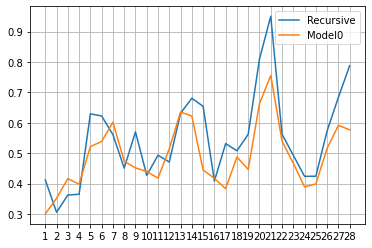

In [51]:
level = 9
plt.plot([i for i in range(1,29)], [analyzeDay(predictions, i, level) for i in range(1,29)])
plt.plot([i for i in range(1,29)], [analyzeDay(bestModel, i, level) for i in range(1,29)])
plt.legend(["Recursive","Model0"])
plt.xticks(range(1,29))
plt.grid(True)
plt.show()

In [548]:
temp_count = 0
mod_preds = m5.transformer[12](predictions)
mod_actuals = m5.transformer[12](m5.actuals)
arr1 = np.square(mod_preds - mod_actuals)
arr2 = np.square(np.round(m5.transformer[12](predictions)) - m5.transformer[12](m5.actuals))
for idx in range(30490):
    a = arr1[idx].sum()
    b = arr2[idx].sum()
    if a < b:
        temp_count += 1
print(temp_count)

22033


In [470]:
def getFudged2(y_pred, y_true):
    residual = (y_true - y_pred).astype("float")
    full_store_range = range(3049 * 8 + 2226, 3049 * 9)
    return np.sqrt(np.sum(np.square(residual[full_store_range].sum(axis = 0))))

def getNormal2(y_pred, y_true):
    residual = (y_true - y_pred).astype("float")
    fudger = 3049 * 8 + 2297
    residual[fudger] = 0
    full_store_range = range(3049 * 8 + 2226, 3049 * 9)
    return np.sqrt(np.sum(np.square(residual[full_store_range].sum(axis = 0))))

def compare(predictions):
    temp_preds = np.copy(predictions)
    fudger = 3049 * 8 + 2297
    temp_preds[fudger] = 0
    return m5.WRMSSE(predictions).computeLevelLosses(9)[62], m5.WRMSSE(temp_preds).computeLevelLosses(9)[62]

In [464]:
fudger = 3049 * 8 + 2297
predictions[fudger]

array([73.40302472, 53.90781358, -1.29858219, -6.19285436,  4.22879762,
        9.17956724,  0.39135545, 81.62706125, 95.92853078, 16.87490097,
       74.78096325, 81.49446273, 18.86907478, 58.28664483, 52.91210572,
        8.27210414, 33.85531025, 52.51515099,  9.94858255, 50.34414281,
       64.93558264, 16.55557991,  4.78382894,  8.57977991,  2.00367538,
       11.11250415, 19.87399582, 26.66190655])

In [471]:
compare(predictions)

(0.003113939378169548, 0.0033517283823194205)

In [467]:
predictions[fudger]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

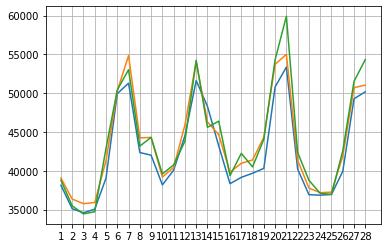

In [45]:
level = 1
plt.plot(range(1,29), [np.sum(m5.transformer[level](predictions), axis = 0)[day] for day in range(28)])
plt.plot(range(1,29), [np.sum(m5.transformer[level](bestModel), axis = 0)[day] for day in range(28)])
plt.plot(range(1,29), [np.sum(m5.transformer[level](m5.actuals), axis = 0)[day] for day in range(28)])
plt.xticks(range(1,29))

plt.grid(True)

In [215]:
np.sum(m5.transformer[1](predictions), axis=0)

39433.77333782457

In [ ]:
combined = np.concatenate((predictions[:,:4], bestModel[:,4:6], predictions[:,6:8], bestModel[:,8:]), axis=1)

In [170]:
m5.WRMSSE(combined).getTotalLoss()

0.5299977413302546

In [164]:
m5.WRMSSE(bestModel).getTotalLoss()

0.5360565806952426

In [44]:
bestModel = m5.clean(pd.read_csv("Submissions/nt_model_0.csv"))

In [111]:
bestLoss = m5.WRMSSE(bestModel)

In [113]:
bestLoss.getLossByLevel()

array([0.02061844, 0.02763055, 0.03697214, 0.02917736, 0.0364879 ,
       0.03603486, 0.04293453, 0.04489379, 0.0513724 , 0.06998631,
       0.07011418, 0.06983413])

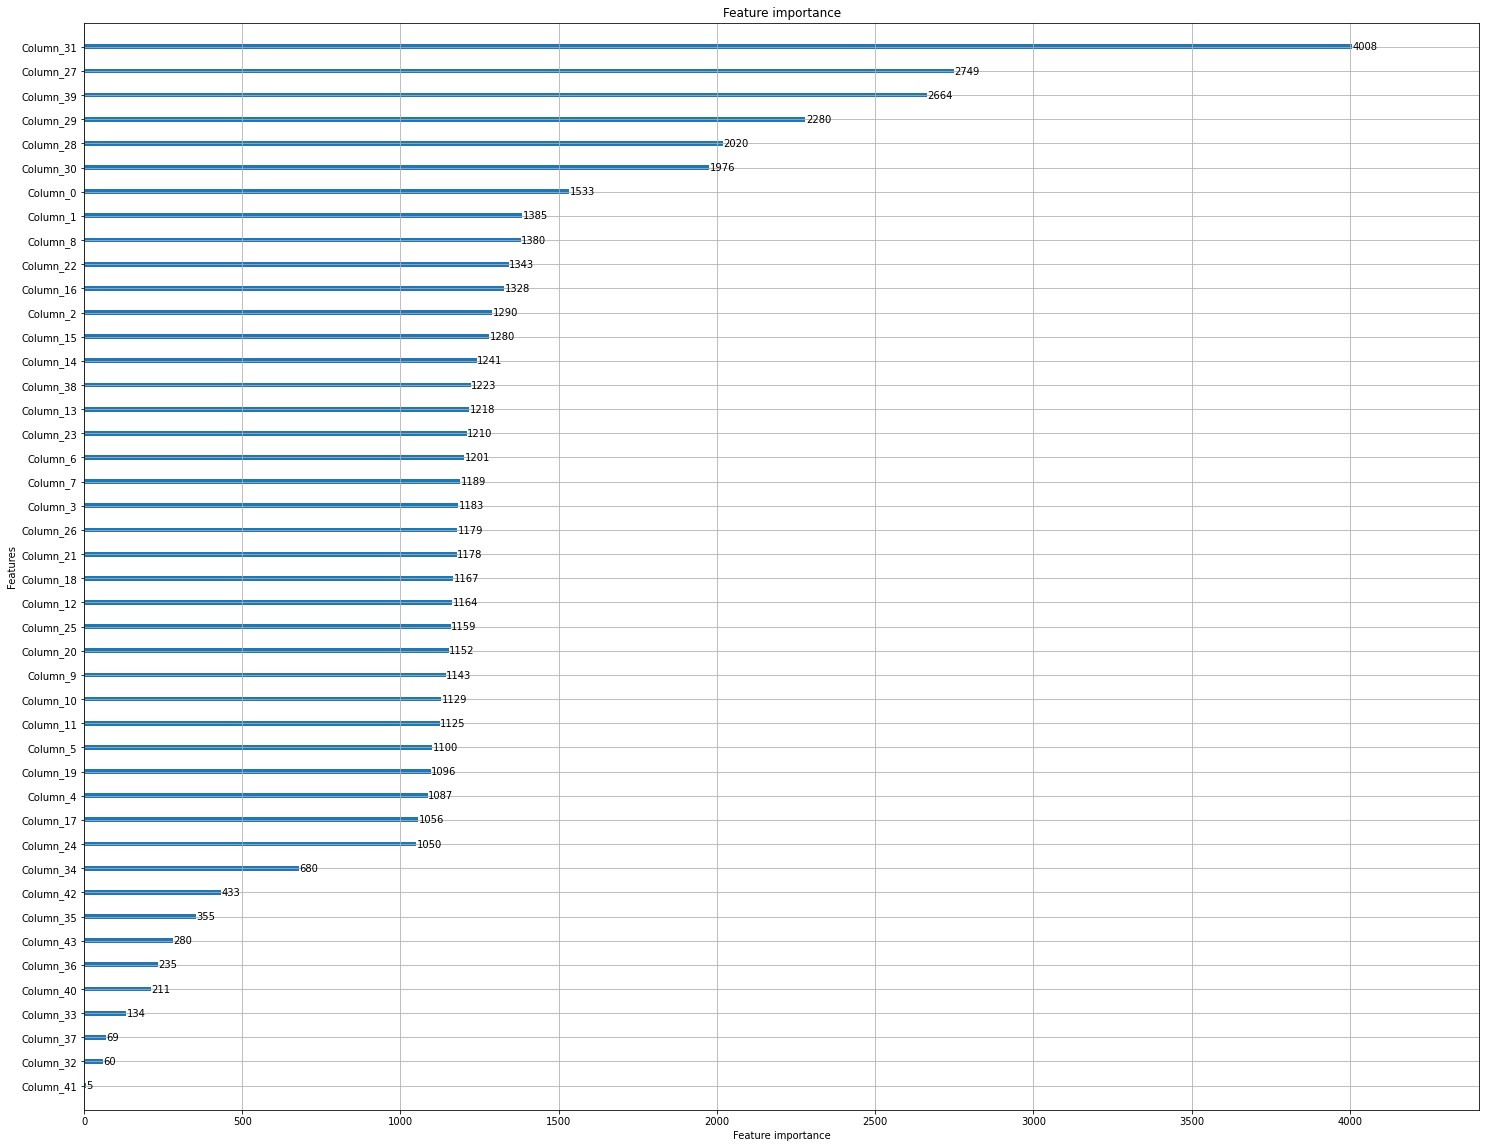

In [886]:
lgb.plot_importance(model, height=0.2, figsize=(25,20))

In [118]:
categories

[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]

In [149]:
training_data[0][37]

0.0

In [262]:
print(Counter(list(m5.calendar.iloc[1200:][m5.calendar["event_name_2"]] )))
print(Counter(list(m5.calendar.iloc[1200:]["event_name_1"])))

Counter({nan: 767, "Father's day": 2})
Counter({nan: 706, 'MemorialDay': 3, 'NBAFinalsStart': 3, 'NBAFinalsEnd': 3, 'Ramadan starts': 3, 'IndependenceDay': 2, 'Eid al-Fitr': 2, 'LaborDay': 2, 'EidAlAdha': 2, 'ColumbusDay': 2, 'Halloween': 2, 'VeteransDay': 2, 'Thanksgiving': 2, 'Chanukah End': 2, 'Christmas': 2, 'NewYear': 2, 'OrthodoxChristmas': 2, 'MartinLutherKingDay': 2, 'SuperBowl': 2, 'ValentinesDay': 2, 'PresidentsDay': 2, 'LentStart': 2, 'LentWeek2': 2, 'Purim End': 2, 'StPatricksDay': 2, 'Easter': 2, 'Pesach End': 2, 'OrthodoxEaster': 2, 'Cinco De Mayo': 2, "Mother's day": 2, "Father's day": 1})


First thing - add in special days

Try running models - both symmetric and aysmetric (symmetric scored .606, fixed mothers day error but now underpredicts heavily on the portion after mothers day, this could be fixed with assymetric loss)

add in unique item identifier (as well as max_bin by node)

try running models - both symmetric and asymmetric

In [244]:
m5.WRMSSE(np.concatenate((predictions[:,:13], bestModel[:,13:14], predictions[:,14:]),axis = 1)).getTotalLoss()

0.6016827523199795

In [489]:
m5.transformer[9](all_data)

array([[ 528.,  489.,  409., ...,  471.,  621.,  641.],
       [  28.,    9.,    6., ...,   56.,   49.,   73.],
       [ 361.,  350.,  279., ...,  695.,  933., 1022.],
       ...,
       [ 152.,  138.,  127., ...,  261.,  324.,  317.],
       [ 583.,  585.,  575., ...,  507.,  505.,  557.],
       [2293., 2383., 1841., ..., 1897., 2411., 2233.]])

## Training a pre-trained Model (Level 9 + 12 Gradient) with Level 6 Loss

In [745]:
len(l8_idxs)

31

In [907]:
[1,2] + [2,3]

[1, 2, 2, 3]

In [850]:
hello = np.array([6,5,3,2])
def arr(hello):
    hello[0] = 5

In [852]:
hello

array([5, 5, 3, 2])

In [740]:
level1MSE(np.array([[1, 2, 3], [3, 4, 5]]), 3)[0]

array([ -8., -12., -16., ...,  -8., -12., -16.])

In [742]:
custom_asymmetric_train(np.array([6,1,4]), np.array([6,5,3]))

(array([-0. , -9.2,  2. ]), array([2.3, 2.3, 2. ]))

In [816]:
%%time
for idx, (a, b) in enumerate(zip(np.random.rand(10000),np.random.rand(10000))):
    pass

CPU times: user 3.23 ms, sys: 412 µs, total: 3.64 ms
Wall time: 3.13 ms


In [815]:
%%time
temp_count = 0 
for a, b, c in zip(np.zeros(10000),np.random.rand(10000),np.random.rand(10000)):
    # print(a,b,c)
    pass

CPU times: user 3.86 ms, sys: 198 µs, total: 4.06 ms
Wall time: 3.76 ms


In [819]:
np.concatenate((np.tile([1,2,3], 2), np.tile([5,6,7], 3)))

array([1, 2, 3, 1, 2, 3, 5, 6, 7, 5, 6, 7, 5, 6, 7])

[4160, 1490, 5320, 5150, 2160, 3980, 8230]

In [829]:
np.concatenate((np.array([2]), np.array([1])))

array([2, 1])

In [849]:
df.iloc[1612]

id          FOODS_1_001_CA_1_validation
item_id                     FOODS_1_001
dept_id                         FOODS_1
cat_id                            FOODS
store_id                           CA_1
                       ...             
d_1909                                1
d_1910                                0
d_1911                                1
d_1912                                1
d_1913                                0
Name: 1612, Length: 1919, dtype: object

In [836]:
categories

[31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]

In [848]:
%%time
dept_idxs + [594503503]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


[0, 416, 565, 1097, 1612, 1828, 2226, 594503503]

In [842]:
2+2

4